## <font color='orange'>NLP (Natural Language Processing) и Обучение с учителем (Supervised Learning)</font>

### <font color='orange'> Данные</font>

Источник: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

Эти данные изначально были получены из библиотеки "Crowdflower's Data for Everyone".

#### Цель: создать алгоритм машинного обучения, который для нового твита будет определять его эмоциональную окраску - позитивный, нейтральный или негативный твит. Такой алгоритм можно будет применять для автоматического чтения твитов и поиска тех твитов, на которые следует обратить внимание службе поддержки клиентов той или иной авиакомпании.

<font color='orange'> Загружаем библиотеки </font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

import warnings
warnings.filterwarnings('ignore')

### <font color='orange'> Варианты извлечения признаков в Scikit-Learn</font>

In [2]:
text = ['This is a line',
           "This is another line",
       "Completely different line"]

Создаем bag of words, где будем подсчитано, сколько то или иное слово встречалось в тексте

In [3]:
#Создадим вектор, где будут учтены стоп-слова
cv = CountVectorizer(stop_words = 'english')

#Формируем словарь и подсчитываем слова
cv.fit_transform(text)

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

Разреженая матрица имеет размер 3х3, так как 3 - это наши три строки в списке, а 3 - это количество уникальных слов во всей переменной без учета стоп-слов ('is', 'a').


In [4]:
cv.vocabulary_

{'line': 2, 'completely': 0, 'different': 1}

Преобразуем разреженную матрицу в обычную

In [5]:
#Сохраним разреженную матрицу в переменную
sparse_matrix = cv.fit_transform(text)

#Преобразовываем (лучше не запускать для больших матриц)
sparse_matrix.todense()

matrix([[0, 0, 1],
        [0, 0, 1],
        [1, 1, 1]], dtype=int64)

Данную матрицу можно соотнести с полученным ранее словарем. Например, 'another' - имеет индекс '0', и мы видим, что оно встречается (то есть обозначается как 1 в матрице) только во второй строке.

Мы можем посчитать частоту встречи тех или иных слов.
Если нам не нужны промежуточные результаты, можно сразу запустить TFidfVectorizer

In [6]:
tv = TfidfVectorizer()

#Создаем разреженную матрицу
tv_result = tv.fit_transform(text)

#Преобразовываем в обычную
tv_result.todense()

matrix([[0.        , 0.        , 0.        , 0.61980538, 0.48133417,
         0.61980538],
        [0.63174505, 0.        , 0.        , 0.4804584 , 0.37311881,
         0.4804584 ],
        [0.        , 0.65249088, 0.65249088, 0.        , 0.38537163,
         0.        ]])

### <font color='orange'> Классификация текстовых данных </font>

In [7]:
df = pd.read_csv('airline_tweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


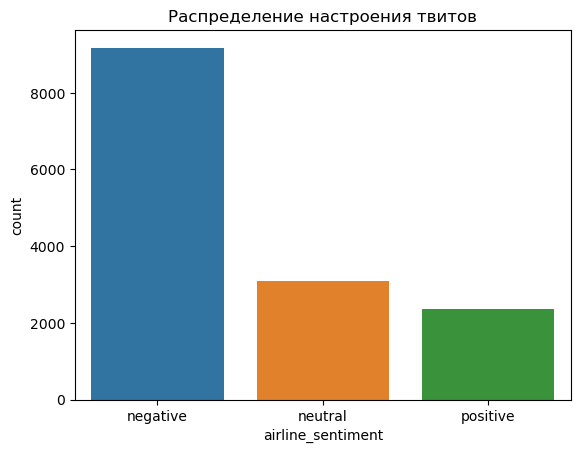

In [9]:
sns.countplot(data = df,
             x = 'airline_sentiment',
             order = df['airline_sentiment'].value_counts().index).set_title('Распределение настроения твитов');

Видим, что данные распределены неравномерно, и у нас преобладает количество негативных твитов. Так как в нашу задачу входит только определение негативных титов, мы объединим позитивные и нейтральные в один класс

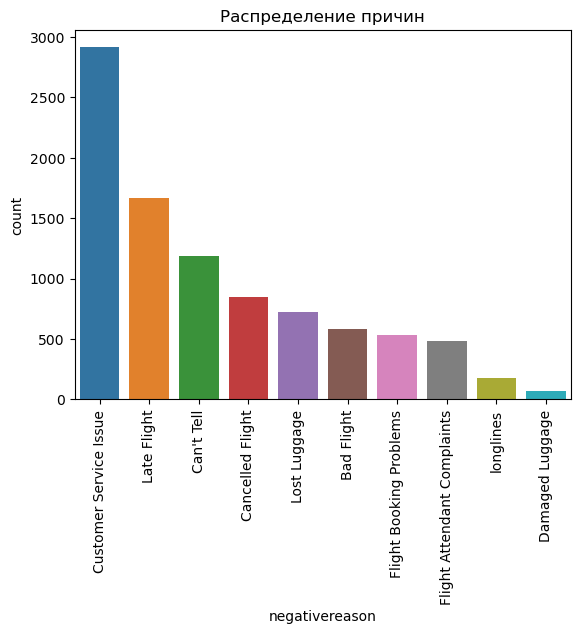

In [10]:
sns.countplot(data = df,
             x = 'negativereason',
             order = df['negativereason'].value_counts().index).set_title('Распределение причин')
plt.xticks(rotation=90);

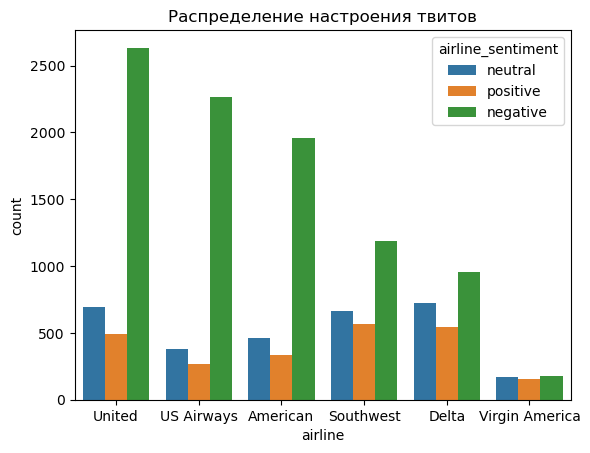

In [11]:
sns.countplot(data =df,
             x = 'airline',
             hue = 'airline_sentiment',
             order = df['airline'].value_counts().index).set_title('Распределение настроения твитов');

### Создание модели

#### <font color = 'orange'> Подготовка текстовых данных </font>

In [12]:
#Отсеем ненужные признаки
data = df[['airline_sentiment','text']]

#Выделим целевую переменную
y = df['airline_sentiment']
X = df['text']

#Разбиение на обучающий и тестовый наборы данных 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Векторизация текста
tfidf = TfidfVectorizer(stop_words='english')

#Обучение модели
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf

<11712x12971 sparse matrix of type '<class 'numpy.float64'>'
	with 107073 stored elements in Compressed Sparse Row format>

#### <font color = 'orange'> Сравнение эффективности моделей с параметрами по умолчанию </font>

In [13]:
def report(model):
    model.fit(X_train_tfidf,y_train)
    preds = model.predict(X_test_tfidf)
    print(classification_report(y_test,preds))
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test)
    

<font color = 'green'> Байесовский алгоритм </font>

NB MODEL
              precision    recall  f1-score   support

    negative       0.66      0.99      0.79      1817
     neutral       0.79      0.15      0.26       628
    positive       0.89      0.14      0.24       483

    accuracy                           0.67      2928
   macro avg       0.78      0.43      0.43      2928
weighted avg       0.73      0.67      0.59      2928



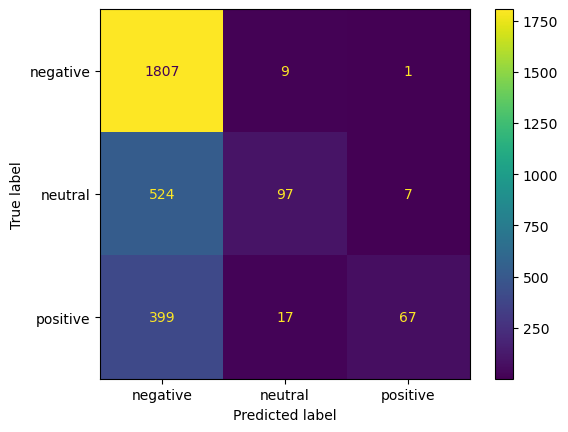

In [14]:
nb = MultinomialNB()
print("NB MODEL")
report(nb)

Получили не очень хорошие результаты для нейтральных твитов, но нас интересуют только негативные. Согласно матрице ошибок, наша модель неправильно классифицировала только 10 твитов, при этом она неверно классифицирует 524 и 399 положительных и нейтральных твитов, оценивая их как негативные.

Низкие значения метрик recall и f1-score показывают, что модель часто ошибается

<font color = 'green'> Логистическая регрессия </font>

Logistic Regression
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1817
     neutral       0.63      0.47      0.54       628
    positive       0.82      0.58      0.68       483

    accuracy                           0.77      2928
   macro avg       0.75      0.66      0.69      2928
weighted avg       0.77      0.77      0.76      2928



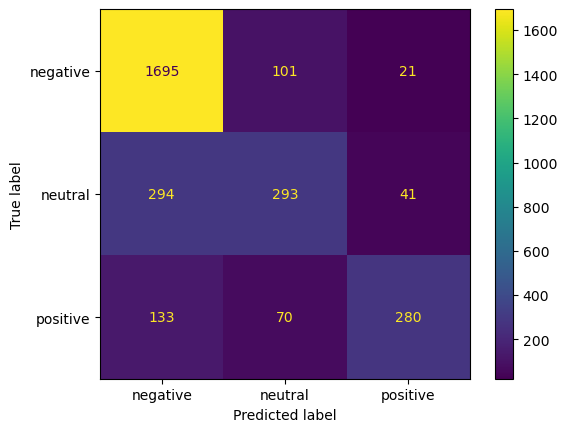

In [15]:
log = LogisticRegression(max_iter=1000)

print("Logistic Regression")
report(log)

Видим, что f1-score выглядит заметно лучше, как и матрица. Да, здесь больше негативных твиттов, которые модель определила неправильно (122), но зато она лучше разбивает твиты на все три класса

<font color = 'green'> Метод опорных векторов </font>

SVC
              precision    recall  f1-score   support

    negative       0.82      0.89      0.86      1817
     neutral       0.59      0.52      0.55       628
    positive       0.76      0.64      0.69       483

    accuracy                           0.77      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.76      0.77      0.77      2928



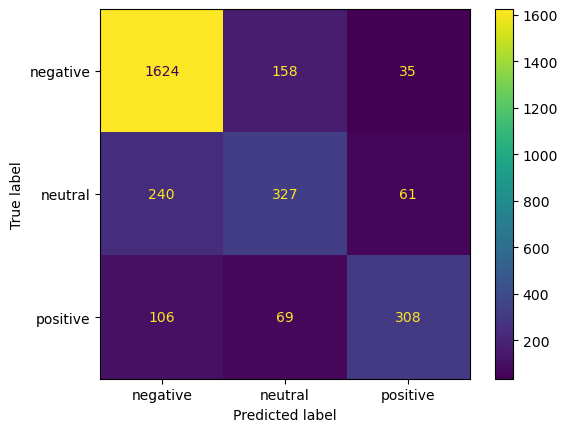

In [16]:
svc = LinearSVC()

print('SVC')
report(svc)

Данная модель показывает примерно такие же оценки, как и в предыдущем случае, но немного хуже.

### <font color = 'orange'> Создание пайплайна для применения к новым твитам </font>
После того, как мы получили хорошо работающую модель, создаем пайплайн (то есть все шаги обработки исходных данных), который можно будет применять напрямую к входным текстовым данным (твитам).

In [17]:
#Векторизация данных
pipe = Pipeline([('tfidf',TfidfVectorizer()),('svc',LinearSVC())])

#Обучение модели на всех данных
pipe.fit(df['text'],df['airline_sentiment'])


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

Попробуем на новом твите

In [18]:
new_tweet_1 = ['good flight']
new_tweet_2 = ['bad flight']
new_tweet_3 = ['ok flight']
a = pipe.predict(new_tweet_1)
b = pipe.predict(new_tweet_2)
c = pipe.predict(new_tweet_3)
print(f'{new_tweet_1} is {a} tweet,\n{new_tweet_2} is {b} tweet,\n{new_tweet_3} is {c} tweet.')


['good flight'] is ['positive'] tweet,
['bad flight'] is ['negative'] tweet,
['ok flight'] is ['neutral'] tweet.
